In [1]:
#importing dependencies
import numpy as np
import os
import pickle as pkl
import math
from math import log2
import utils
from collections import Counter, defaultdict
import copy
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.utils.random import sample_without_replacement

import pandas as pd
import unidecode
from collections import defaultdict
from vsm import *

import unidecode

In [2]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [45]:
import en_core_web_sm
nlp = en_core_web_sm.load()

# some helper functions
def remove_stop_words(words):
    return [word for word in words if not nlp.vocab[word].is_stop]

def remove_numeric(words):
    return [word for word in words if word.isalpha()]

def clean_words(words):
    # standardize accents
    return [unidecode.unidecode(word) for word in words]
    # remove words that are not alpha
    #return remove_numeric(words)

def normalize(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        norm = 1 # avoid division by 0
    return vector / norm

In [4]:
base_dir_name = os.getcwd()
data_dir_name = "project_data"
data_dir = os.path.join(base_dir_name, data_dir_name)

### Analyzing data

In [5]:
def load_data(signal_filename, relevance_filename, vocab_dict, vocab_id_list, vocab_frequency):
    
    # We will return these 7 things!
    query_dict = {} #maps queries to query id (Assuming distinct queries)
    doc_dict = {}  #maps docs to doc id
    query_doc_dict = {} #maps query ids to list of doc ids
    query_id_list = [] #list
    doc_id_list = []
    query_doc_relevance = {}
    docId_to_content = {} #dict maps from doc id to the contents in the doc. The content is saved as a list of vocab_ids
    results_dict = {
        'query_dict': query_dict,
        'doc_dict': doc_dict,
        'query_doc_dict': query_doc_dict,
        'query_id_list': query_id_list,
        'doc_id_list': doc_id_list,
        'query_doc_relevance': query_doc_relevance,
        'docId_to_content': docId_to_content,
    }
    
    doc_list_for_query = []
    query_repetitions = {} #dict mapping queries to number of repetitions
    query_counter = 0
    doc_repetitions = 0

    with open(os.path.join(data_dir, signal_filename), "r", encoding='utf8') as f:
        last_query_id = 0 
        for line in f:
            line_list = line.split()
            if line_list[0] == 'query:':
                query_counter += 1
                if query_counter >= 2:
                    query_doc_dict[last_query_id] = doc_list_for_query

                query = " ".join(line_list[1:])

                if query_dict.get(query, None) != None:
                    query_repetitions[query] = query_repetitions.get(query, 0) + 1
                    query = query + "_" + str(query_repetitions[query])

                query_id_list.append(query)
                query_dict[query] = len(query_id_list) - 1

                last_query_id = len(query_id_list) - 1 #update the last query whenever a new query starts
                doc_list_for_query = [] #reinitialize the doc list whenever a new query starts

            elif line_list[0] == 'url:':
                assert len(line_list) == 2, "line_list for url has more than 2 entries. Please check!"
                doc = line_list[1]
                if doc_dict.get(doc, None) == None:
                    doc_id_list.append(doc)
                    doc_id = len(doc_id_list) -1
                    doc_dict[doc] = doc_id
                else:
                    doc_id = doc_dict[doc]
                if doc_id not in doc_list_for_query: 
                    doc_list_for_query.append(doc_id)

            else:
                continue

        query_doc_dict[last_query_id] = doc_list_for_query


    query_total_repetitions = copy.deepcopy(query_repetitions)
    doc_relevance_dict = {}
    query_counter = 0
    with open(os.path.join(data_dir, relevance_filename), "r", encoding='utf8') as f:
        for line in f:
            line_list = line.split()
            if line_list[0] == 'query:':
                query_counter += 1
                query = " ".join(line_list[1:])
                if query_repetitions.get(query, None) != None:
                    query_repetition_number = query_total_repetitions[query] - query_repetitions[query]
                    query_repetitions[query] -= 1
                    if query_repetition_number != 0:
                        query = query + "_" + str(query_repetition_number)

                if query_counter >= 2:
                    assert query_doc_relevance.get(last_query_id, None) == None, "Query already existed in the relevance dict"
                    query_doc_relevance[last_query_id] = doc_relevance_dict

                last_query_id = query_dict[query]
                doc_relevance_dict = {}

            elif line_list[0] == "url:":
                doc = line_list[1]
                docID = doc_dict[doc]

                doc_relevance_dict[docID] = float(line_list[-1].strip())

        query_doc_relevance[last_query_id] = doc_relevance_dict
        
    #building word corpus for each document
    doc_counter = 0
    last_doc_content = defaultdict(list)

    with open(os.path.join(data_dir, signal_filename), "r", encoding='utf8') as f:
        for line in f:
            line_list = line.split()

            if line_list[0] == 'query:':
                query = " ".join(line_list[1:])
                queryID = query_dict[query]
                for word in line_list[1:]:
                    word = word.strip().lower()
                    vocab_frequency[word] = vocab_frequency.get(word, 0) + 1

                    if vocab_dict.get(word, None) == None:
                        vocab_id_list.append(word)
                        vocab_dict[word] = len(vocab_id_list) - 1

            elif line_list[0] == 'url:':
                doc_counter += 1

                doc = line_list[1]
                docID = doc_dict[doc]

                if doc_counter >= 2:
                    docId_to_content[last_docID] = last_doc_content

                last_doc_content = defaultdict(list)
                last_docID = docID

            elif line_list[0] == 'title:':
                for word in line_list[1:]:
                    word = word.strip().lower()
                    vocab_frequency[word] = vocab_frequency.get(word, 0) + 1

                    if vocab_dict.get(word, None) == None:
                        vocab_id_list.append(word)
                        vocab_dict[word] = len(vocab_id_list) - 1

                    word_id = vocab_dict[word]
                    last_doc_content['title'].append(word_id)

            elif line_list[0] == 'header:':
                for word in line_list[1:]:
                    word = word.strip().lower()
                    vocab_frequency[word] = vocab_frequency.get(word, 0) + 1

                    if vocab_dict.get(word, None) == None:
                        vocab_id_list.append(word)
                        vocab_dict[word] = len(vocab_id_list) - 1

                    word_id = vocab_dict[word]
                    last_doc_content['header'].append(word_id)

            else:
                continue

        docId_to_content[last_docID] = last_doc_content
    return results_dict

In [6]:
#vocab includes words from both, query and docs
vocab_dict = {} #mapping from vocab term to id 
vocab_id_list = [] #list where id maps to the vocab term (0 indexed)
vocab_frequency = {} #number of times each vocab term appears in the vocab of documents (included query words)

train_dict = load_data("pa3.signal.train", "pa3.rel.train", vocab_dict, vocab_id_list, vocab_frequency)
dev_dict = load_data("pa3.signal.dev", "pa3.rel.dev", vocab_dict, vocab_id_list, vocab_frequency)
pkl.dump(dev_dict['doc_id_list'], open('dev_doc_id_list.p', 'wb'))
pkl.dump(dev_dict['doc_dict'], open('dev_doc_dict.p', 'wb'))


## Comparing query and document embeddings

Document embeddings are obtained from the given title or header information without any weight normalization. Loop through the files and collect doc words by looking in the title and header (one idea can be to give more weight to title than to header). Lookup for each word in the glove embedding. Choose and fix a random combination of word if a word in query does not exist (maybe a combination from the words university and around because the corpus relates to stanford). Ignore otherwise. Finally, find cosine similarity and rank and compute NDCG score. 

#### Other ideas:
1. Treat upper case and start of line word different than end of line word, etc
2. Can add word correction, etc
3. How scraping documents and adding more words to document effect performance
4. Modeling item-item dependency by seq2slate architecture
5. Creating embedding for words in the query but not in the embedding vocab as a distinct combination for 
6. Training word2vec on this and then trying different ideas with the center and context matrices obtained
7. DESM type ideas with the embeddings of words in the document weighted by the similarity of words (W_out * q_emb)
8. Treating re-ranking task as an NLI task where document entails query
9. regressing score for each query-doc pair using nlp inspired regression by predicting score through RNN for instance
10. experimenting with listwise and pairwise approaches

## Abstracting away data structures


In [7]:
"""
data structures we need:
    query_dict = {} #maps queries to query id (Assuming distinct queries)
    query_id_list = [] #list of queries

    doc_dict = {}  #maps urls to doc id
    doc_id_list = [] # list of urls

    query_doc_dict = {} #maps query ids to list of doc ids
    
    docId_to_content = {} #dict maps from doc id to the contents in the doc. The content is saved as a list of vocab_ids

    #vocab includes words from both, query and docs
    vocab_dict = {} #mapping from vocab term to id 
    vocab_id_list = [] #list where id maps to the vocab term (0 indexed)
    vocab_frequency = {} 
"""   
# dataset_dict is an argument to most of these, 
# as we need to know if we are dealing with train set, dev set
def get_query_string(dataset_dict, query):
    if type(query) == int:
        query = dataset_dict['query_id_list'][query]
    assert type(query) == str, query
    return query

def get_query_id(dataset_dict, query):
    if type(query) == str:
        query = dataset_dict['query_dict'][query]
    assert type(query) == int, query
    return query
 
def get_doc_url(dataset_dict, doc):
    if type(doc) == int:
        doc = dataset_dict['doc_id_list'][doc]
    assert type(doc) == str, doc
    return doc

def get_doc_id(dataset_dict, doc):
    if type(doc) == str:
        doc = dataset_dict['doc_dict'][doc]
    assert type(doc) == int, doc
    return doc

# this should be common to everything across train/dev
def ids_to_words(content):
    # convert ids to words
    return [vocab_id_list[i] if type(i) == int else i for i in content]
    #return [vocab_id_list[i] for i in content]

# this should be common to everything across train/dev
def words_to_ids(words):
    return [vocab_dict[w] if type(w) == str else w for w in words]
    #return [vocab_dict[w] for w in words]

# this should be common to everything across train/dev
def register_words(words):
    for word in words:
        if word not in vocab_dict:
            vocab_dict[word] = len(vocab_id_list)
            vocab_id_list.append(word)

def get_query_words(dataset_dict, query):
    # return a list of words corresponding to the query (either string query or query_id)
    query = get_query_string(dataset_dict, query)
    return query.split('_')[0].split(' ')
    
def get_doc_words(dataset_dict, document, content_type):
    # given either url or doc_id
    document = get_doc_id(dataset_dict, document)
    # all documents have a title at least
    doc_to_content = dataset_dict['docId_to_content']
    title_content = doc_to_content[document]['title']
    
    if content_type == 'title':
        content = title_content
    
    elif content_type == 'header':
        if doc_to_content[document]['header']:
            content = doc_to_content[document]['header']
        else:
            content = title_content
    
    elif content_type == '2th':
        content = 2*title_content
        content += doc_to_content[document]['header']
    
    elif content_type == 'body':
        if doc_to_content[document]['body']:
            content = doc_to_content[document]['body']
        else:
            content = title_content
        
    else:
        raise ValueError("Invalid content type: {}".format(content_type))

    return ids_to_words(content)

def get_all_doc_words(dataset_dict, query, content_type):
    # return tuples of (url, content) corresponding 
    query = get_query_id(dataset_dict, query)
    query_doc_dict = dataset_dict['query_doc_dict']
    documents = [get_doc_url(dataset_dict, doc) for doc in query_doc_dict[query]]
    return [(doc, get_doc_words(dataset_dict, doc, content_type)) for doc in documents]

def get_relevance_dict(dataset_dict, query):
    query = get_query_id(dataset_dict, query)
    query_doc_relevance = dataset_dict['query_doc_relevance']
    return {get_doc_url(dataset_dict, k): v for k, v in query_doc_relevance[query].items()}

def query_iter(dataset_dict):
    query_dict = dataset_dict['query_dict']
    for query in query_dict:
        yield query

def url_iter(dataset_dict, query):
    query_doc_dict = dataset_dict['query_doc_dict']
    query = get_query_id(dataset_dict, query)

    for doc in query_doc_dict[query]:
        yield get_doc_url(dataset_dict, doc)
        
# Note: from here on out, you NEVER have to touch a datastructure, just use the functions above

## Inject the body content (by url) into docId_to_content when available

In [8]:
def make_url_to_body(s="train"):
    name = "{}_web_url_to_body.p".format(s)
    if not os.path.exists(name):
        print("Making dictionary")
        web_vocab_id_list = pkl.load(open('{}_vocab_id_list.p'.format(s), 'rb'))
        web_vocab_dict = pkl.load(open('{}_vocab_dict.p'.format(s), 'rb'))
        web_docId_to_content = pkl.load(open('{}_doc_id_content.p'.format(s), 'rb'))
        web_doc_id_list = pkl.load(open("{}_doc_id_list.p".format(s), "rb"))
        web_doc_dict = pkl.load(open("{}_doc_dict.p".format(s), "rb"))
        web_url_to_words = {}

        for url, doc in web_doc_dict.items():
            body_content = []
            if doc in web_docId_to_content:
                _, body_content = web_docId_to_content[doc]

            body_content = [web_vocab_id_list[w] for w in body_content]
            web_url_to_words[url] = body_content

        pkl.dump(web_url_to_words, open(name, "wb"))

    else:
        print("Loading dictionary")
        web_url_to_words = pkl.load(open(name, "rb"))
    return web_url_to_words

train_web_url_to_words = make_url_to_body('train')
dev_web_url_to_words = make_url_to_body('dev')

Loading dictionary
Loading dictionary


In [9]:
def fill_in(dataset_dict, web_url_to_words):
    present, missing = 0, 0
    for query in query_iter(dataset_dict):
        for url in url_iter(dataset_dict, query):
            if url in web_url_to_words:
                content = web_url_to_words[url]
                doc_id = get_doc_id(dataset_dict, url)
                register_words(content)
                content = words_to_ids(content)
                docId_to_content = dataset_dict['docId_to_content']
                docId_to_content[doc_id]['body'] = content
                present += 1
            else:
                missing += 1
    return present, missing

print(fill_in(train_dict, train_web_url_to_words))
print(fill_in(dev_dict, dev_web_url_to_words))


(7201, 0)
(1187, 0)


In [10]:
# some sanity checks
for query in query_iter(train_dict):
    print(get_query_words(train_dict, query))
    print()
    print(get_all_doc_words(train_dict, query, 'title'))
    print()
    print(get_relevance_dict(train_dict, query))
    print()
    for url in url_iter(train_dict, query):
        print(url)
    break


['stanford', 'aoerc', 'pool', 'hours']

[('http://events.stanford.edu/2014/February/18/', ['events', 'at', 'stanford', 'tuesday', 'february', '18', '2014']), ('http://events.stanford.edu/2014/February/6/', ['events', 'at', 'stanford', 'thursday', 'february', '6', '2014']), ('http://events.stanford.edu/2014/March/13/', ['events', 'at', 'stanford', 'thursday', 'march', '13', '2014']), ('http://events.stanford.edu/2014/March/3/', ['events', 'at', 'stanford', 'monday', 'march', '3', '2014']), ('http://med.stanford.edu/content/dam/sm/hip/documents/FreeFitnessWeek.pdf', ['ffw', 'spring', '2017', 'schedule']), ('http://web.stanford.edu/group/masters/pool.html', ['stanford', 'masters', 'swimming', 'pool', '&', 'parking', 'information']), ('https://alumni.stanford.edu/get/page/perks/PoolAndGyms', ['pool', '&', 'gyms']), ('https://cardinalrec.stanford.edu/facilities/aoerc/', []), ('https://explorecourses.stanford.edu/search?view=catalog&filter-coursestatus-Active=on&page=0&catalog=&q=PE+128%3A+S

In [11]:
for query in query_iter(dev_dict):
    print(get_query_words(dev_dict, query))
    print()
    print(get_all_doc_words(dev_dict, query, 'title'))
    print()
    print(get_relevance_dict(dev_dict, query))
    print()
    for url in url_iter(dev_dict, query):
        print(url)
    break

['lost', 'axess', 'password', 'help']

[('https://accounts.stanford.edu/', ['stanford', 'accounts']), ('https://accounts.stanford.edu/resetpw', ['stanford', 'accounts', 'reset', 'password', 'step', '1', 'of', '4']), ('https://uit.stanford.edu/announcements/security', ['announcements', 'university', 'it']), ('https://uit.stanford.edu/service/webauth/twostep', ['two', 'step', 'authentication', 'university', 'it']), ('https://uit.stanford.edu/service/webauth/twostep/bypass_code', ['how', 'to', 'generate', 'a', 'bypass', 'code', 'for', 'a', 'lost', 'or', 'forgotten', 'two', 'step', 'authentication', 'device', 'university', 'it']), ('https://uit.stanford.edu/service/webauth/twostep/printed_list', ['how', 'to', 'use', 'a', 'printed', 'list', 'for', 'two', 'step', 'authentication', 'university', 'it']), ('https://uit.stanford.edu/service/webauth/twostep/push', ['how', 'to', 'authenticate', 'with', 'a', 'duo', 'push', 'notification', 'for', 'two', 'step', 'authentication', 'university', 'it'])

## Set up GloVe embedding

In [119]:
'''having generated query content and doc content, lets try ranking by cosine similarity between query and document 
embedding
'''
#iteration 1: ignore words not there in the embedding

#lookup function
glove_dim = 100
GLOVE_HOME = os.path.join('data', 'glove.6B')
glove_lookup = utils.glove2dict(os.path.join(GLOVE_HOME, 'glove.6B.{}d.txt'.format(glove_dim)))

In [12]:
def make_glove_embedding(words, combine_func=None, is_query=None):
    # is_query is ignored, added to play nice with make_vsm_embedding
    for word in words:
        assert isinstance(word, str), (type(word), word)

    all_vecs = np.array([glove_lookup[w] for w in words if w in glove_lookup]) 

    if len(all_vecs) == 0:
        feats = np.zeros(glove_dim)    
    else:       
        if combine_func:
            feats = combine_func(all_vecs)
        else: # take the elemnetwise mean by default
            feats = np.mean(all_vecs, axis=0) 
    return feats

def query_and_document_embeddings(dataset_dict, query, query_combine_func=None, doc_combine_func=None, content_type='title', embedding_func=None):
    """
    query: Either query text, or id
    query_combine_func: How to combine query GloVe embeddings (default is mean)
    doc_combine_func: How to combine document GloVe embeddings (default is mean)
    doc_content_type: How to select document content. TODO: make this do something
    """
    if embedding_func is None:
        embedding_func = make_glove_embedding
        
    query_words = get_query_words(dataset_dict, query)
    query_embedding = embedding_func(query_words, query_combine_func, is_query=True)
        
    document_embeddings = [(url, embedding_func(words, doc_combine_func, is_query=False)) 
                               for url, words in get_all_doc_words(dataset_dict, query, content_type)]
    return query_embedding, document_embeddings

### Metric - NDCG, MAP

can also incorporate Precision, MAP, etc. after binary conversion with decay rates

In [13]:
def DCG(ranked_docs, relevance_dict):
    '''This function takes an ordered/ranked document list with the ground truth relevance labels from the 
    relevance_dict and returns a DCG score for the retrieval/ranking.
    Input -- 
        ranked_docs = list of doc IDs ordered by rank. First element in the list is the highest ranked
        relevance_dict = dict with keys as the doc_IDs and relevance score as the element
    Output -- 
        DCG [float]'''
    return np.sum([(relevance_dict[doc]) / (math.log2(i+2)) \
                  for i, doc in enumerate(ranked_docs)])

def DCG_alt(ranked_docs, relevance_dict):
    return np.sum([(2**relevance_dict[doc] - 1) / (math.log2(i+2)) \
                   for i, doc in enumerate(ranked_docs)])

def NDCG(ranked_docs, relevance_dict, use_alt=False):
    '''This function takes an ordered/ranked document list with the ground truth relevance labels from the 
    relevance_dict and returns a NDCG score for the ranking. 
    Input -- 
        ranked_docs = list of doc IDs ordered by rank. First element in the list is the highest ranked
        relevance_dict = dict with keys as the doc_IDs and relevance score as the element
    Output -- 
        NDCG [float]'''
    assert len(ranked_docs) == len(relevance_dict)
    ideal_ordering, _ = zip(*sorted(relevance_dict.items(), key = lambda x: (-x[1])))
    ideal_ordering = list(ideal_ordering)
    
    dcg_func = DCG_alt if use_alt else DCG
    DCG_oracle = dcg_func(ideal_ordering, relevance_dict)
    DCG_case = dcg_func(ranked_docs, relevance_dict)
    assert DCG_oracle >= DCG_case
    
    #return 0 if DCG_ideal is 0 (happens when all the retrieved docs are rated 0)
    if DCG_oracle == 0:
        return 1.0

    return DCG_case/DCG_oracle

#sanity check
ranked_docs = [0,1,2,3,4]
relevance_dict = {0: 2, 1: 3, 2: 0, 3: 0, 4: 1}
DCG_score = 2 + 3/log2(3) + 1/log2(6)
Ideal_score = 3 + 2/log2(3) + 1/log2(4)
NDCG_score = DCG_score/Ideal_score
assert DCG(ranked_docs, relevance_dict) == DCG_score, "DCG error"
assert NDCG(ranked_docs, relevance_dict) == NDCG_score, "NDCG error"

In [14]:
def average_precision_helper(relevance_list):
    precision = 0.0
    relevant_so_far = 0.0
    for i, val in enumerate(relevance_list):
        relevant_so_far += val
        precision += relevant_so_far / (i+1)
    return precision / len(relevance_list)

def average_precision(ranked_doc_list, query_relevance_dict):
    relevance_list = [1 if query_relevance_dict[doc] >= 1.0 else 0 for doc in ranked_doc_list]
    return average_precision_helper(relevance_list)

expected = (1 + 1 + 2/3 + 2/4 + 3/5 + 3/6 + 4/7)/ 7
actual = average_precision_helper([1, 1, 0, 0, 1, 0, 1])
assert expected == actual, actual


In [15]:
def random_similarity(doc_embedding, query_embedding):
    return np.random.uniform()

def cosine_similarity(doc_embedding, query_embedding):
    doc_embedding = normalize(doc_embedding)
    return np.dot(doc_embedding, query_embedding)


In [16]:
def run_metrics(dataset_dict, scoring_func=cosine_similarity, 
                content_type='title', embedding_func=None, set_name='dev', exp_name='(None)'):
    ndcg_sum = 0.0
    alt_ndcg_sum = 0.0
    precision_sum = 0.0
    n = 0
    for query in query_iter(dataset_dict):
        n += 1
        query_relevance_dict = get_relevance_dict(dataset_dict, query)
        query_embedding, document_embeddings = \
                query_and_document_embeddings(dataset_dict, query, content_type=content_type, embedding_func=embedding_func)
        
        scores = [(url, scoring_func(doc_emb, query_embedding)) for url, doc_emb in document_embeddings]
        scores = sorted(scores, key = lambda x: x[1], reverse=True)
        ranked_doc_list, _ = zip(*scores)
        ranked_doc_list = list(ranked_doc_list)

        ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict)
        alt_ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict, use_alt=True)
        precision_sum += average_precision(ranked_doc_list, query_relevance_dict)
        
    ndcg_sum /= n
    alt_ndcg_sum  /= n
    precision_sum /= n
    return {'NDCG': ndcg_sum,
            'Alt_NDCG': alt_ndcg_sum,
            'MAP': precision_sum,
            'type': set_name,
            'name': exp_name}

## Random ordering accuracy

For every query, arrange the docs in random order and check the NDCG value

In [19]:
n = 10
sum_metric = {}
for _ in range(n):
    for m, v in run_metrics(train_dict, scoring_func=random_similarity).items():
        if type(v) != str:
            sum_metric[m] = sum_metric.get(m, 0) + v / n
print("Random on train")
sum_metric

Random on train


{'NDCG': 0.809529579371248,
 'Alt_NDCG': 0.7422079090196728,
 'MAP': 0.7241636182584593}

In [22]:
n = 10
sum_metric = {}
for _ in range(n):
    for m, v in run_metrics(dev_dict, scoring_func=random_similarity).items():
        if type(v) != str:
            sum_metric[m] = sum_metric.get(m, 0) + v / n
print("Random on dev")
sum_metric

Random on dev


{'NDCG': 0.8062319836467401,
 'Alt_NDCG': 0.7347451765535957,
 'MAP': 0.7181887945590422}

# Some non-random methods


In [23]:
print("Title on train")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='title')

Title on train


{'NDCG': 0.8651824860113435,
 'Alt_NDCG': 0.8161245513899243,
 'MAP': 0.7771249238087184,
 'type': 'dev',
 'name': '(None)'}

In [24]:
print("Title on dev")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='title')

Title on dev


{'NDCG': 0.8610811796421569,
 'Alt_NDCG': 0.8111389290875022,
 'MAP': 0.7623313263477439,
 'type': 'dev',
 'name': '(None)'}

In [25]:
print("Header on train")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='header')

Header on train


{'NDCG': 0.8568503022704564,
 'Alt_NDCG': 0.8042551360163497,
 'MAP': 0.7661671476556811,
 'type': 'dev',
 'name': '(None)'}

In [26]:
print("Header on dev")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='header')

Header on dev


{'NDCG': 0.8595995880298966,
 'Alt_NDCG': 0.8048907651704151,
 'MAP': 0.7704660869724235,
 'type': 'dev',
 'name': '(None)'}

In [27]:
print("2*Title+header on train")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='2th')

2*Title+header on train


{'NDCG': 0.8685425184105349,
 'Alt_NDCG': 0.8196390620542968,
 'MAP': 0.778713179048508,
 'type': 'dev',
 'name': '(None)'}

In [28]:
print("2*Title+header on dev")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th')

2*Title+header on dev


{'NDCG': 0.8702515039354958,
 'Alt_NDCG': 0.8221430739588372,
 'MAP': 0.776288219588911,
 'type': 'dev',
 'name': '(None)'}

In [29]:
print("Body on train")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='body')

Body on train


{'NDCG': 0.8538332875849136,
 'Alt_NDCG': 0.7968008388330325,
 'MAP': 0.7690100740266438,
 'type': 'dev',
 'name': '(None)'}

In [30]:
print("Body on dev")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='body')

Body on dev


{'NDCG': 0.8706960262890675,
 'Alt_NDCG': 0.8121585630178958,
 'MAP': 0.7961876798210322,
 'type': 'dev',
 'name': '(None)'}

# Let's do Machine Learning

In [115]:
def regression_featurizer_factory(embedder, content_type=None, combine_func=None, 
                                  remove_stop=False, combination_type=None):
    assert content_type is not None
    if combine_func is None:
        combine_func = lambda arr: np.mean(arr, axis=0)
    assert combination_type in ['concat', 'mult', 'both']
    
    """
    Returns a function that can be called to featurize data when making a regression dataset
    """
    def featurizer(dataset_dict, query, url):
    
        query_words = get_query_words(dataset_dict, query)
        doc_words = get_doc_words(dataset_dict, url, content_type)

        if remove_stop:
            query_words = remove_stop_words(query_words)
            doc_words = remove_stop_words(doc_words)

        query_embedding = embedder(query_words, combine_func, is_query=True)
        document_embedding = embedder(doc_words, combine_func, is_query=False) 

        if combination_type == 'concat':
            return np.concatenate([query_embedding, document_embedding])
        elif combination_type == 'mult':
            return query_embedding * document_embedding
        elif combination_type == 'both':
            return np.concatenate([query_embedding, document_embedding, query_embedding * document_embedding])
        else:
            raise ValueError("Invalid combination type {}".format(combination_type))
        
    return featurizer

glove_concat_featurizer_title = regression_featurizer_factory(make_glove_embedding, content_type='title', combination_type='concat')
glove_concat_featurizer_header = regression_featurizer_factory(make_glove_embedding, content_type='header', combination_type='concat')
glove_concat_featurizer_2_title_header = regression_featurizer_factory(make_glove_embedding, content_type='2th', combination_type='concat')
glove_concat_featurizer_body = regression_featurizer_factory(make_glove_embedding, content_type='body', combination_type='concat')    

In [116]:
def make_regression_dataset(dataset_dict, featurizer, repetitive=False):
    """
        dataset_dict: returned by load_data
        featurizer: function that takes in (query, doc_content) pair and returns a featurization
        
        makes a dataset of (vector, relevance) pair where vector is made by the featurizer
    """
    X, y = [], []
    for query in query_iter(dataset_dict): 
        relevances = get_relevance_dict(dataset_dict, query)
        for url in url_iter(dataset_dict, query):
            embedding = featurizer(dataset_dict, query, url)
            if repetitive:
                for emb in embedding: # repetitive means its a list of embeddings, not just one
                    X.append(emb)
                    y.append(relevances[url])
            else:
                X.append(embedding)
                y.append(relevances[url])
    return np.array(X), np.array(y)

In [117]:
def run_metrics_ml(dataset_dict, ml_model, featurizer, set_name='dev', exp_name='(None)'):
    """
        dataset_dict: the dictionary returned by load_data
        ml_model: a model that takes in X and outputs y predictions
        featurizer: the featurizer function that feeds (query, document) 
            pairs to a format the ml_model can accept
    """
    # TODO: shouldnt have to use the featurizer here, need to improve this API
    ndcg_sum = 0.0
    alt_ndcg_sum = 0.0
    precision_sum = 0.0
    n = 0
    for query in query_iter(dataset_dict):
        n += 1
        query_relevance_dict = get_relevance_dict(dataset_dict, query)
        
        to_rank = [(url, featurizer(dataset_dict, query, url)) for url in url_iter(dataset_dict, query)]
        vectors = [vector for _, vector in to_rank]
        predictions = ml_model.predict(vectors)
        scores = [(url, predictions[i]) for i, (url, _) in enumerate(to_rank)]
        
        scores = sorted(scores, key = lambda x: x[1], reverse=True)
        ranked_doc_list, _ = zip(*scores)
        ranked_doc_list = list(ranked_doc_list)

        ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict)
        alt_ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict, use_alt=True)
        precision_sum += average_precision(ranked_doc_list, query_relevance_dict)
        
    ndcg_sum /= n
    alt_ndcg_sum  /= n
    precision_sum /= n
    return {'NDCG': ndcg_sum,
            'Alt_NDCG': alt_ndcg_sum,
            'MAP': precision_sum,
            'type': set_name,
            'name': exp_name}

In [122]:
training_dataset_title = make_regression_dataset(train_dict, glove_concat_featurizer_title)
#training_dataset_header = make_regression_dataset(train_dict, glove_concat_featurizer_header)
#training_dataset_body = make_regression_dataset(train_dict, glove_concat_featurizer_body)

In [80]:
class LinearReg:
    def __init__(self):
        self.model = LinearRegression()
        
    def train(self, dataset):
        X, y = dataset
        self.model = self.model.fit(X, y)
        return self.model.score(X, y)
    
    def predict(self, X):
        return self.model.predict(X)     

In [125]:
print("Linear Regression with title GloVe embeddings")
lin_reg = LinearReg()
lin_reg.train(training_dataset_title)
run_metrics_ml(dev_dict, lin_reg, glove_concat_featurizer_title)

Linear Regression with title GloVe embeddings


{'NDCG': 0.8542825508514621,
 'Alt_NDCG': 0.7973529372338085,
 'MAP': 0.7603503995684292,
 'type': 'dev',
 'name': '(None)'}

In [142]:
glove_both_featurizer_2_title_header = regression_featurizer_factory(make_glove_embedding, content_type='2th', combination_type='both')
training_dataset_2_title_header_poly = make_regression_dataset(train_dict, glove_both_featurizer_2_title_header)

In [143]:
lin_reg = LinearReg()
lin_reg.train(training_dataset_2_title_header_poly)
print("trained")
run_metrics_ml(dev_dict, lin_reg, glove_both_featurizer_2_title_header, set_name='dev', 
               exp_name='LinReg with GloVe poly embeddings')

trained


{'NDCG': 0.8594486185683073,
 'Alt_NDCG': 0.8044780768696508,
 'MAP': 0.7660226025894227,
 'type': 'dev',
 'name': 'LinReg with GloVe poly embeddings'}

In [147]:
nn_small = small_neural_net_factory()
nn_small.train(training_dataset_2_title_header_poly)
print("trained")
run_metrics_ml(dev_dict, nn_small, glove_both_featurizer_2_title_header, set_name='dev', 
               exp_name='One layer NN with GloVe poly embeddings')


trained


{'NDCG': 0.8741622025809409,
 'Alt_NDCG': 0.8255334815413925,
 'MAP': 0.7800603010021213,
 'type': 'dev',
 'name': 'One layer NN with GloVe poly embeddings'}

In [146]:
class NeuralNetReg:
    def __init__(self, **kwargs):
        self.model = MLPRegressor(**kwargs)
        
    def train(self, dataset):
        X, y = dataset
        self.model = self.model.fit(X, y)
        return self.model.score(X, y)
    
    def predict(self, X):
        return self.model.predict(X)     

In [40]:
def neural_net_factory():
    return NeuralNetReg(hidden_layer_sizes=(100,50), activation='relu', solver='adam')

In [144]:
def small_neural_net_factory():
    return NeuralNetReg(hidden_layer_sizes=(100), activation='relu', solver='adam')

In [96]:
class Ensemble:
    def __init__(self, model_factory, num_models, split=0.8):
        self.num_models = num_models
        self.split = split
        self.models = [model_factory() for _ in range(num_models)]
        
    def train(self, dataset):
        X, y = dataset
        n = len(y)
        for model_idx in range(self.num_models):
            indices = sample_without_replacement(n, n*self.split)
            self.models[model_idx].train((X[indices], y[indices]))
    
    def predict(self, X):
        # linearly interpolate between all the models
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X) / self.num_models
        return predictions

In [138]:
def softmax(arr):
    arr = np.exp(arr)
    return arr / np.sum(arr)

class EnsembleWithEval:
    def __init__(self, model_factory, num_models, split=0.8):
        assert split < 1.0, split
        self.num_models = num_models
        self.split = split
        self.models = [model_factory() for _ in range(num_models)]
        self.evaluations = [None] * num_models
        
    def train(self, dataset):
        X, y = dataset
        n = len(y)
        for model_idx in range(self.num_models):
            indices = sample_without_replacement(n, n*self.split)
            eval_indices = [i for i in range(n) if i not in set(indices)]
            assert len(eval_indices) > 0
            
            self.models[model_idx].train((X[indices], y[indices]))
            self.evaluate(model_idx, X[eval_indices], y[eval_indices])
        
        # normalize evaluations
        self.evaluations = np.array(self.evaluations) / np.sum(self.evaluations)
        
    def predict(self, X):
        # linearly interpolate between all the models based on their evaluations
        predictions = np.zeros(len(X))
        for model_idx, model in enumerate(self.models):
            predictions += model.predict(X) * self.evaluations[model_idx]
        return predictions
    
    def evaluate(self, model_idx, X, y):
        self.evaluations[model_idx] = 1. / np.mean(np.square(self.models[model_idx].predict(X) - y))

# Make VSM embedding

In [131]:
def make_co_occurence(dataset_dict):
    epsilon = 0.1
    counts = defaultdict(lambda: defaultdict(int))
    for query in query_iter(dataset_dict):
        query_words = clean_words(get_query_words(dataset_dict, query))
        relevance_dict = get_relevance_dict(dataset_dict, query)
        for url in url_iter(dataset_dict, query):
            title_words = 2 * clean_words(get_doc_words(dataset_dict, url, content_type='title')) # count the title words twice
            header_words = clean_words(get_doc_words(dataset_dict, url, content_type='header'))
            weight = epsilon + relevance_dict[url]
            for q_word in query_words:
                for d_word in title_words + header_words:
                    counts[q_word][d_word] += weight
    return counts

def short_print(co_occurence_dict):
    n, m = 10, 10
    i = 0
    for q_word in co_occurence_dict:
        i += 1
        if i > n:
            break
        print('\n' + q_word + ':')

        j = 0
        for d_word in co_occurence_dict[q_word]:
            print(d_word + ',' + str(co_occurence_dict[q_word][d_word]))
            j += 1
            if j > m:
                break
        print(len(co_occurence_dict[q_word]))
    
counts = pd.DataFrame(make_co_occurence(train_dict)).fillna(value=0)

In [132]:
doc_vsm_title = counts
query_vsm_title = counts.copy().transpose()

In [133]:
def transform_vsm(df, k=100):
    return lsa(pmi(df), k).transpose()  # TODO: fix this tranpose business

In [149]:
def vsm_embedder_factory(query_df_counts, doc_df_counts, k=100):
    query_vsm = transform_vsm(query_df_counts, k)
    doc_vsm = transform_vsm(doc_df_counts, k)
    
    def make_vsm_embedding(words, combine_func=None, is_query=True):
        for word in words:
            assert isinstance(word, str), (type(word), word)

        if is_query:
            lookup = query_vsm
        else:
            lookup = doc_vsm

        #for DESM, each vector should be normalized

        all_vecs = np.array([normalize(lookup[w]) for w in words if w in lookup]) 

        if len(all_vecs) == 0:
            feats = np.zeros(lookup.values.shape[0])    
        else:

            if combine_func:
                feats = combine_func(all_vecs)
            else: # take the elementwise mean by default
                feats = np.mean(all_vecs, axis=0)
        return feats
    
    return make_vsm_embedding


make_vsm_embedding_title_100 = vsm_embedder_factory(query_vsm_title, doc_vsm_title, k=100)
make_vsm_embedding_title_200 = vsm_embedder_factory(query_vsm_title, doc_vsm_title, k=200)

In [135]:
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th', 
            embedding_func=make_vsm_embedding_title_100, set_name='dev', exp_name='Standard VSM embeddings length 100')

{'NDCG': 0.8507632511523792,
 'Alt_NDCG': 0.794216545803379,
 'MAP': 0.756990611208641,
 'type': 'dev',
 'name': 'Standard VSM embeddings length 100'}

In [136]:
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th', 
            embedding_func=make_vsm_embedding_title_200, set_name='dev', exp_name='Standard VSM embeddings length 200')

{'NDCG': 0.8522612530018778,
 'Alt_NDCG': 0.7974018981664599,
 'MAP': 0.7629867282934678,
 'type': 'dev',
 'name': 'Standard VSM embeddings length 200'}

In [137]:
vsm_concat_featurizer = regression_featurizer_factory(make_vsm_embedding, content_type='2th', 
                                                      combination_type='concat')
vsm_mult_featurizer =  regression_featurizer_factory(make_vsm_embedding, content_type='2th', 
                                                      combination_type='mult')
vsm_poly_featurizer =  regression_featurizer_factory(make_vsm_embedding, content_type='2th', 
                                                      combination_type='both')

glove_concat_featurizer = regression_featurizer_factory(make_glove_embedding, content_type='2th', 
                                                      combination_type='concat')
glove_mult_featurizer = regression_featurizer_factory(make_glove_embedding, content_type='2th', 
                                                      combination_type='mult')
glove_both_featurizer = regression_featurizer_factory(make_glove_embedding, content_type='2th', 
                                                      combination_type='both')

## Some analysis to see how many dims we should take from the VSM embeddings

In [29]:
def svd_plot(df, c=10):
    rowmat, singvals, colmat = np.linalg.svd(df, full_matrices=False)
    plt.plot(range(len(singvals)), singvals)
    plt.title("Singular values")
    plt.ylabel("Singular value")
    plt.xlabel("Index")
    
    #print the number of eigenvalues to take before the sum is c times the rest
    k = 0
    while sum(singvals[:k]) < c*sum(singvals[k:]):
        k += 1
    print("Use {} dimensions".format(k))
    
    return rowmat, singvals, colmat


Use 168 dimensions


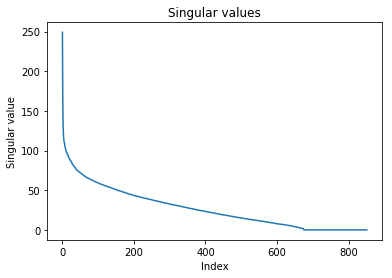

In [30]:
U, S, Vt = svd_plot(pmi(doc_vsm), c=1)

In [ ]:
def lsa_tune(df_1, df_2, k_list):
    """Latent Semantic Analysis using pure scipy.

    Parameters
    ----------
    df : pd.DataFrame
       The matrix to operate on.
    k : int (default: 100)
        Number of dimensions to truncate to.

    Returns
    -------
    pd.DataFrame
        The SVD-reduced version of `df` with dimension (m x k), where
        m is the rowcount of mat and `k` is either the user-supplied
        k or the column count of `mat`, whichever is smaller.

    """
    rowmat_1, singvals_1, colmat_1 = np.linalg.svd(df_1, full_matrices=False)
    rowmat_2, singvals_2, colmat_2 = np.linalg.svd(df_2, full_matrices=False)

    singvals_1 = np.diag(singvals_1)
    singvals_2 = np.diag(singvals_2)
    for k in k_list:
        trunc_1 = np.dot(rowmat_1[:, 0:k], singvals_1[0:k, 0:k])
        trunc_2 = np.dot(rowmat_2[:, 0:k], singvals_2[0:k, 0:k])

        yield (pd.DataFrame(trunc_1, index=df_1.index), pd.DataFrame(trunc_2, index=df_2.index))

In [131]:
k_list = [50, 100, 150, 200, 250, 300]
i = 0
for q_vsm, d_vsm in lsa_tune(pmi(query_vsm), pmi(doc_vsm), k_list):
    k = k_list[i]
    i += 1
    q_vsm = q_vsm.transpose()
    d_vsm = d_vsm.transpose()
    
    def tune_vsm_embedding(words, combine_func=None, is_query=True):
        for word in words:
            assert isinstance(word, str), (type(word), word)

        if is_query:
            lookup = q_vsm
        else:
            lookup = d_vsm

        #for DESM, each vector should be normalized

        all_vecs = np.array([normalize(lookup[w]) for w in words if w in lookup]) 

        if len(all_vecs) == 0:
            feats = np.zeros(lookup.values.shape[0])    
        else:

            if combine_func:
                feats = combine_func(all_vecs)
            else: # take the elementwise mean by default
                feats = np.mean(all_vecs, axis=0)
        return feats

    print("k =", k)
    print(run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th', embedding_func=tune_vsm_embedding))

k = 50
{'NDCG': 0.8417815658077111, 'Alt_NDCG': 0.7819818026851135, 'MAP': 0.7474935233950208, 'type': 'dev', 'name': '(None)'}
k = 100
{'NDCG': 0.8507632511523792, 'Alt_NDCG': 0.794216545803379, 'MAP': 0.756990611208641, 'type': 'dev', 'name': '(None)'}
k = 150
{'NDCG': 0.8542710777266654, 'Alt_NDCG': 0.7997838787450877, 'MAP': 0.7632202365713312, 'type': 'dev', 'name': '(None)'}
k = 200
{'NDCG': 0.8522612530018778, 'Alt_NDCG': 0.7974018981664599, 'MAP': 0.7629867282934678, 'type': 'dev', 'name': '(None)'}
k = 250
{'NDCG': 0.8570996484467451, 'Alt_NDCG': 0.8041851534054328, 'MAP': 0.7664812452758882, 'type': 'dev', 'name': '(None)'}
k = 300
{'NDCG': 0.8570419234548257, 'Alt_NDCG': 0.804873609491111, 'MAP': 0.7641292014117477, 'type': 'dev', 'name': '(None)'}


## Try embedding query words the same, but document words based on co-occurence within all body text (within window)

In [54]:
from tqdm import tqdm

def most_popular(dataset_dict, top=5000):
    counts = {}
    for query in tqdm(query_iter(dataset_dict)):
        for url in url_iter(dataset_dict, query):
            body_words = clean_words(get_doc_words(dataset_dict, url, content_type='body'))
            for word in body_words:
                counts[word] = counts.get(word, 0) + 1
    most_popular = sorted([(v, k) for k, v in counts.items()], reverse=True)[:top]
    return set([k for v, k in most_popular])

def make_window_co_occurence(dataset_dict, k=5):
    counts = {}
    to_keep = most_popular(dataset_dict) # dont' count words outside of the top 5k
    for query in tqdm(query_iter(dataset_dict)):
        for url in url_iter(dataset_dict, query):
            body_words = [w for w in clean_words(get_doc_words(dataset_dict, url, content_type='body')) if w in to_keep]
            for i, first_word in enumerate(body_words):
                if first_word not in counts:
                    counts[first_word] = {}
                for j in range(max(0, i-k), min(i+k+1, len(body_words))):
                    second_word = body_words[j]
                    if second_word not in counts[first_word]:
                        counts[first_word][second_word] = 0
                    counts[first_word][second_word] += 1
    return counts

doc_counts_body  = make_window_co_occurence(train_dict)

749it [00:09, 76.19it/s] 
749it [00:50, 14.79it/s]


In [55]:
doc_counts = pd.DataFrame(doc_counts).fillna(value=0)

Use 1162 dimensions


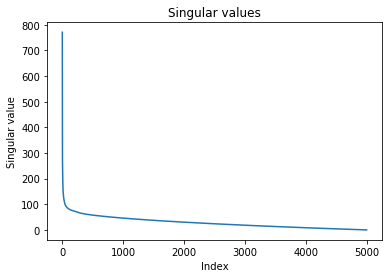

In [57]:
_ = svd_plot(pmi(doc_counts), c=1)

In [71]:
doc_body_vsm = doc_counts

In [72]:
make_vsm_embedding = vsm_embedder_factory(query_vsm, doc_body_vsm, k=200)
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th', 
            embedding_func=make_vsm_embedding, set_name='dev', exp_name='Embed doc words based on body text')

{'NDCG': 0.8126775220097986,
 'Alt_NDCG': 0.7375369838446545,
 'MAP': 0.7374502139565505,
 'type': 'dev',
 'name': 'Embed doc words based on body text'}

In [93]:
training_dataset_vsm_poly = make_regression_dataset(train_dict, vsm_poly_featurizer)

In [103]:
lin_reg = LinearReg()
lin_reg.train(training_dataset_vsm_poly)
print("trained")
run_metrics_ml(dev_dict, lin_reg, vsm_poly_featurizer, set_name='dev', 
               exp_name='LinReg with VSM poly embeddings from body content')

trained


{'NDCG': 0.8507433299627585,
 'Alt_NDCG': 0.789507893885919,
 'MAP': 0.7685820197254529,
 'type': 'dev',
 'name': 'LinReg with VSM poly embeddings from body content'}

In [139]:
lin_reg_ensemble = Ensemble(LinearReg, 5)
lin_reg_ensemble.train(training_dataset_vsm_poly)
print("trained")
run_metrics_ml(dev_dict, lin_reg_ensemble, vsm_poly_featurizer, set_name='dev', 
               exp_name='LinReg Ensemble with VSM poly embeddings from body content')

trained


{'NDCG': 0.8488608286064229,
 'Alt_NDCG': 0.7888354777904943,
 'MAP': 0.7644821306658864,
 'type': 'dev',
 'name': 'LinReg Ensemble with VSM poly embeddings from body content'}

In [140]:
lin_reg_ensemble = EnsembleWithEval(LinearReg, 5)
lin_reg_ensemble.train(training_dataset_vsm_poly)
print("trained")
run_metrics_ml(dev_dict, lin_reg_ensemble, vsm_poly_featurizer, set_name='dev', 
               exp_name='LinReg EnsembleWithEval with VSM poly embeddings from body content')

trained


{'NDCG': 0.8480981293411232,
 'Alt_NDCG': 0.7853457454250327,
 'MAP': 0.7649933100480334,
 'type': 'dev',
 'name': 'LinReg EnsembleWithEval with VSM poly embeddings from body content'}

In [ ]:
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th', 
            embedding_func=make_vsm_embedding, set_name='dev', exp_name='Embed doc words based on body text')

# Try both Glove and VSM embeddings combined

In [153]:
def make_glove_and_vsm_embedding(words, combine_func=None, is_query=True):
    vsm = make_vsm_embedding_title_100(words, combine_func=combine_func, is_query=is_query)
    glove = make_glove_embedding(words, combine_func=combine_func, is_query=is_query)
    return np.concatenate([vsm, glove])

In [154]:
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th', 
            embedding_func=make_glove_and_vsm_embedding, set_name='dev', exp_name='Use both VSM and GloVe embeddings')

{'NDCG': 0.8688145224429039,
 'Alt_NDCG': 0.820474393827041,
 'MAP': 0.7755825744276209,
 'type': 'dev',
 'name': 'Use both VSM and GloVe embeddings'}

In [155]:
glove_and_vsm_poly_featurizer =  regression_featurizer_factory(make_glove_and_vsm_embedding, content_type='2th', 
                                                        combination_type='both')
training_dataset_glove_vsm_poly = make_regression_dataset(train_dict, glove_and_vsm_poly_featurizer)

In [156]:
lin_reg = LinearReg()
lin_reg.train(training_dataset_glove_vsm_poly)
print("trained")
run_metrics_ml(dev_dict, lin_reg, glove_and_vsm_poly_featurizer, set_name='dev', 
               exp_name='LinReg with both GloVe and VSM poly embeddings from body content')

trained


{'NDCG': 0.8689434817447704,
 'Alt_NDCG': 0.8153732301184206,
 'MAP': 0.7852327920415476,
 'type': 'dev',
 'name': 'LinReg with both GloVe and VSM poly embeddings from body content'}

## Try training small nn ensembles for Glove, VSM, and Glove + VSM

In [161]:
glove_poly_featurizer =  regression_featurizer_factory(make_glove_embedding, content_type='2th', 
                                                               combination_type='both')
training_dataset_glove_poly = make_regression_dataset(train_dict, glove_poly_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset_glove_poly)
print("trained")
run_metrics_ml(dev_dict, nn_small_ensemble, glove_poly_featurizer, set_name='dev', 
               exp_name='One layer NN with GloVe poly embeddings from 2th content')

/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

trained


{'NDCG': 0.8820045023014039,
 'Alt_NDCG': 0.8364967144521347,
 'MAP': 0.7937512572233191,
 'type': 'dev',
 'name': 'One layer NN with GloVe poly embeddings from 2th content'}

In [162]:
vsm_poly_featurizer =  regression_featurizer_factory(make_vsm_embedding, content_type='2th', 
                                                               combination_type='both')
training_dataset_vsm_poly = make_regression_dataset(train_dict, vsm_poly_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset_vsm_poly)
print("trained")
run_metrics_ml(dev_dict, nn_small_ensemble, vsm_poly_featurizer, set_name='dev', 
               exp_name='One layer NN with VSM poly embeddings from 2th content')

/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

trained


{'NDCG': 0.8777398450206124,
 'Alt_NDCG': 0.8285844785796038,
 'MAP': 0.7845577621729694,
 'type': 'dev',
 'name': 'One layer NN with VSM poly embeddings from 2th content'}

In [163]:
glove_and_vsm_poly_featurizer =  regression_featurizer_factory(make_glove_and_vsm_embedding, content_type='2th', 
                                                               combination_type='both')
training_dataset_glove_vsm_poly = make_regression_dataset(train_dict, glove_and_vsm_poly_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset_glove_vsm_poly)
print("trained")
run_metrics_ml(dev_dict, nn_small_ensemble, glove_and_vsm_poly_featurizer, set_name='dev', 
               exp_name='One layer NN with both GloVe and VSM poly embeddings from 2th content')

/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


trained


{'NDCG': 0.8906058267364788,
 'Alt_NDCG': 0.8483501811247214,
 'MAP': 0.7991966723965575,
 'type': 'dev',
 'name': 'One layer NN with both GloVe and VSM poly embeddings from 2th content'}

# Experimental Results (Metrics)

In [197]:
all_metrics = []

In [198]:
# Random
n = 10
sum_metric = {}
for _ in range(n):
    for m, v in run_metrics(train_dict, scoring_func=random_similarity, 
                            set_name='train', exp_name='Random scoring').items():
        if type(v) != str:
            sum_metric[m] = sum_metric.get(m, 0) + v / n
sum_metric['name'] = 'Random scoring'
sum_metric['type'] = 'train'
all_metrics.append(sum_metric)

sum_metric = {}
for _ in range(n):
    for m, v in run_metrics(dev_dict, scoring_func=random_similarity, 
                            set_name='dev', exp_name='Random scoring').items():
        if type(v) != str:
            sum_metric[m] = sum_metric.get(m, 0) + v / n
sum_metric['name'] = 'Random scoring'
sum_metric['type'] = 'dev'
all_metrics.append(sum_metric)


In [199]:
metric = run_metrics(train_dict, scoring_func=cosine_similarity, 
                     content_type='2th', set_name='train', exp_name='Cosine similarity with GloVE embeddings')
all_metrics.append(metric)

In [200]:
metric = run_metrics(dev_dict, scoring_func=cosine_similarity, 
                     content_type='2th', set_name='dev', exp_name='Cosine similarity with GloVE embeddings')
all_metrics.append(metric)

In [201]:
metric = run_metrics(train_dict, scoring_func=cosine_similarity, 
                     embedding_func=make_vsm_embedding, set_name='train', exp_name='Cosine similarity with VSM embeddings')
all_metrics.append(metric)

In [202]:
metric = run_metrics(dev_dict, scoring_func=cosine_similarity, 
                     embedding_func=make_vsm_embedding, set_name='dev', exp_name='Cosine similarity with VSM embeddings')
all_metrics.append(metric)

In [203]:
metric = run_metrics(train_dict, scoring_func=cosine_similarity, 
                     embedding_func=make_glove_and_vsm_embedding, set_name='train', 
                     exp_name='Cosine similarity with Glove + VSM embeddings')
all_metrics.append(metric)

In [204]:
metric = run_metrics(dev_dict, scoring_func=cosine_similarity, 
                     embedding_func=make_glove_and_vsm_embedding, set_name='dev', 
                     exp_name='Cosine similarity with Glove + VSM embeddings')
all_metrics.append(metric)


## Small NN ensemble with concat embeddings

In [205]:
glove_concat_featurizer =  regression_featurizer_factory(make_glove_embedding, content_type='2th', 
                                                               combination_type='concat')
vsm_concat_featurizer =  regression_featurizer_factory(make_vsm_embedding, content_type='2th', 
                                                               combination_type='concat')
vsm_glove_concat_featurizer =  regression_featurizer_factory(make_glove_and_vsm_embedding, content_type='2th', 
                                                               combination_type='concat')

In [206]:
training_dataset = make_regression_dataset(train_dict, glove_concat_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, glove_concat_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on concatenated GloVe embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, glove_concat_featurizer,
                        set_name='dev', exp_name='Small NN ensemble on concatenated GloVe embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

In [207]:
training_dataset = make_regression_dataset(train_dict, vsm_concat_featurizer)

nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, vsm_concat_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on concatenated VSM embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, vsm_concat_featurizer,
                        set_name='dev', exp_name='Small NN ensemble on concatenated VSM embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

In [208]:
training_dataset = make_regression_dataset(train_dict, vsm_glove_concat_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, vsm_glove_concat_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on concatenated GloVe + VSM embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, vsm_glove_concat_featurizer,
                        set_name='dev', exp_name='Small NN ensemble on concatenated GloVe + VSM embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Small NN ensemble with multiplied embeddings

In [209]:
glove_mul_featurizer =  regression_featurizer_factory(make_glove_embedding, content_type='2th', 
                                                               combination_type='mult')
vsm_mul_featurizer =  regression_featurizer_factory(make_vsm_embedding, content_type='2th', 
                                                               combination_type='mult')
glove_and_vsm_mul_featurizer =  regression_featurizer_factory(make_glove_and_vsm_embedding, content_type='2th', 
                                                               combination_type='mult')

In [210]:
training_dataset = make_regression_dataset(train_dict, glove_mult_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, glove_mul_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on multiplied GloVe embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, glove_mul_featurizer,
                        set_name='dev', exp_name='Small NN ensemble on multiplied GloVe embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

In [211]:
training_dataset = make_regression_dataset(train_dict, vsm_mul_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, vsm_mul_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on multiplied VSM embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, vsm_mul_featurizer,
                        set_name='dev', exp_name='Small NN ensemble on multiplied VSM embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

In [212]:
training_dataset = make_regression_dataset(train_dict, glove_and_vsm_mul_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, glove_and_vsm_mul_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on multiplied GloVe and VSM embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, glove_and_vsm_mul_featurizer,
                        set_name='dev', exp_name='Small NN ensemble on multiplied GloVe and VSM embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

## Same but with both concat + mult

In [213]:
glove_both_featurizer =  regression_featurizer_factory(make_glove_embedding, content_type='2th', 
                                                               combination_type='both')
vsm_both_featurizer =  regression_featurizer_factory(make_vsm_embedding, content_type='2th', 
                                                               combination_type='both')
glove_and_vsm_both_featurizer =  regression_featurizer_factory(make_glove_and_vsm_embedding, content_type='2th', 
                                                               combination_type='both')

In [214]:
training_dataset = make_regression_dataset(train_dict, glove_both_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, glove_both_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on concatenated and multiplied GloVe embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, glove_both_featurizer,
                        set_name='dev', exp_name='Small NN ensemble on concatenated and multiplied GloVe embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

In [215]:
training_dataset = make_regression_dataset(train_dict, vsm_both_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, vsm_both_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on concatenated and multiplied VSM embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, vsm_both_featurizer,
                        set_name='dev', exp_name='NN ensemble on concatenated and multiplied VSM embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

In [216]:
training_dataset = make_regression_dataset(train_dict, glove_and_vsm_both_featurizer)
nn_small_ensemble = EnsembleWithEval(small_neural_net_factory, 5)
nn_small_ensemble.train(training_dataset)

metric = run_metrics_ml(train_dict, nn_small_ensemble, glove_and_vsm_both_featurizer, 
                        set_name='train', exp_name='Small NN ensemble on concatenated and multiplied GloVe + VSM embeddings')
all_metrics.append(metric)

metric = run_metrics_ml(dev_dict, nn_small_ensemble, glove_and_vsm_both_featurizer,
                        set_name='dev', exp_name='Small NN ensemble on concatenated and multiplied GloVe + VSM embeddings')
all_metrics.append(metric)


/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ssesha/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

In [217]:
metric_frame = pd.DataFrame(all_metrics)

In [218]:
metric_frame = metric_frame[['name', 'type', 'NDCG', 'Alt_NDCG', 'MAP']]

In [219]:
pd.set_option('display.max_colwidth', -1)
metric_frame

,name,type,NDCG,Alt_NDCG,MAP
0,Random scoring,train,0.810559,0.743259,0.726010
1,Random scoring,dev,0.809480,0.739594,0.721148
2,Cosine similarity with GloVE embeddings,train,0.868543,0.819639,0.778713
3,Cosine similarity with GloVE embeddings,dev,0.870252,0.822143,0.776288
4,Cosine similarity with VSM embeddings,train,0.807882,0.741058,0.725608
5,Cosine similarity with VSM embeddings,dev,0.824462,0.753089,0.743511
6,Cosine similarity with Glove + VSM embeddings,train,0.865965,0.817066,0.777946
7,Cosine similarity with Glove + VSM embeddings,dev,0.860184,0.809570,0.762028
8,Small NN ensemble on concatenated GloVe embeddings,train,0.990661,0.984391,0.889707
9,Small NN ensemble on concatenated GloVe embeddings,dev,0.889265,0.843126,0.791556
